### **Librerias**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pycaret
from pmdarima import plot_acf
pd.options.display.max_rows = 20
import warnings
warnings.filterwarnings('ignore')

## **Etapa 0: Crear Data Set**

### PIB

In [2]:
PIB = pd.read_csv('./Datos/PIB.csv', sep=',',encoding='latin-1')
PIB = PIB[(PIB['year']>=2000) & (PIB['year']<=2020)]
PIB['year'] = PIB['year'].astype('int')
PIB['key'] = [(str((PIB.iloc[i,4])).lower()+'-'+str(PIB.iloc[i,6])) for i in range(len(PIB['country_name']))]
PIB = PIB.sort_values(by=['country_name'])
PIB.shape

(4410, 11)

### Complejidad Economica

In [3]:
Data_ECI = pd.read_csv('./Datos/ECI_Data.csv',sep=',',encoding='latin-1')
Data_ECI = Data_ECI.transpose()
Data_ECI = Data_ECI[2:].transpose()
Data_ECI.dropna(inplace=True)

In [4]:
complexity = []
pais = []
año = []
for i in range(len(Data_ECI.iloc[:,:0])):
    for j in range(len(Data_ECI.iloc[0,:-3])):
        pais.append(Data_ECI.iloc[i,22])
        año.append((Data_ECI.columns[j]))
        complexity.append(Data_ECI.iloc[i,j])
ECI = pd.DataFrame()
ECI['Pais'] = pais
ECI['ECI'] = complexity
ECI['año'] = año
ECI['año'] = ECI['año'].astype('int')
ECI['key'] = [(str(ECI.iloc[i,0]).lower()+'-'+str(ECI.iloc[i,2])) for i in range(len(ECI['año']))]
ECI = ECI.sort_values(by=['Pais'])
ECI.shape

(1953, 4)

### Poblacion

In [5]:
Data_Poblacion = pd.read_csv('./Datos/Poblacion_Data.csv', sep=',',encoding='latin-1')
Data_Poblacion.dropna(inplace=True)

In [6]:
Poblacion = []
pais_p = []
año = []
for i in range(len(Data_Poblacion.iloc[:,:0])):
    for j in range(len(Data_Poblacion.iloc[0,4:-2])):
        pais_p.append(Data_Poblacion.iloc[i,0])
        año.append(int(Data_Poblacion.columns[j+4]))
        Poblacion.append(Data_Poblacion.iloc[i,j+4])
Population = pd.DataFrame()
Population['Pais'] = pais_p
Population['Poblacion'] = Poblacion
Population['año'] = año
Population['key'] = [(str(Population.iloc[i,0]).lower()+'-'+str(Population.iloc[i,2])) for i in range(len(Population['año']))]
Population = Population.sort_values(by=['Pais'])

### Region

In [7]:
cordenada = pd.read_csv('./Datos/country-coord.csv', sep=',',encoding='latin-1')
cordenada['country'] = [(str(cordenada.iloc[i,0]).lower()) for i in range(len(cordenada['Country']))]
cordenada.shape

(244, 4)

In [8]:
cordenada.iloc[0,2]

65.0

In [9]:
cordenada['Ecuador'] = [1 if (cordenada.iloc[i,1]<=27 and cordenada.iloc[i,1]>=-27) else 0 for i in range(len(cordenada['country']))]

### Union DataFrames

In [10]:
Data_final = PIB.merge(Population,left_on='key',right_on='key').merge(ECI,left_on='key',right_on='key')
Data_final = Data_final[['Pais_x', 'Poblacion', 'total_gdp_million','ECI','año_x']]
Data_final['country'] = [(str(Data_final.iloc[i,0]).lower()) for i in range(len(Data_final['Pais_x']))]
Data_final = pd.merge(Data_final, cordenada, on ='country', how ='inner')
Data_final = Data_final[['Pais_x', 'Poblacion', 'total_gdp_million','ECI','año_x','Ecuador']]
Data_final.to_csv('Datos/Crecimiento_ec.csv')

## **Etapa 1: Entender los Datos**

In [11]:
Data = pd.read_csv('./Datos/Crecimiento_ec.csv')
Data.drop('Unnamed: 0',axis=1,inplace=True)
Data['año'] = ["".join([str(Data.iloc[i,4]),"-01"]) for i in range(len(Data.año_x))]
Data

,Pais_x,Poblacion,total_gdp_million,ECI,año_x,Ecuador,año
0,Algeria,42705368.0,171767.403700,-1.042459,2019,0,2019-01
1,Algeria,43451666.0,145009.181500,-1.206390,2020,0,2020-01
2,Algeria,30774621.0,54790.392750,-1.064802,2000,0,2000-01
3,Algeria,31200985.0,54744.712810,-0.804064,2001,0,2001-01
4,Algeria,31624696.0,56760.355870,-0.994074,2002,0,2002-01
...,...,...,...,...,...,...,...
1570,Zimbabwe,11984644.0,6342.116400,-0.342388,2002,1,2002-01
1571,Zimbabwe,11910978.0,6777.384700,-0.393783,2001,1,2001-01
1572,Zimbabwe,11834676.0,6689.957600,-0.288579,2000,1,2000-01
1573,Zimbabwe,12679810.0,9665.793264,-0.381771,2009,1,2009-01


In [12]:
Data.head(5)

,Pais_x,Poblacion,total_gdp_million,ECI,año_x,Ecuador,año
0,Algeria,42705368.0,171767.40370,-1.042459,2019,0,2019-01
1,Algeria,43451666.0,145009.18150,-1.206390,2020,0,2020-01
2,Algeria,30774621.0,54790.39275,-1.064802,2000,0,2000-01
3,Algeria,31200985.0,54744.71281,-0.804064,2001,0,2001-01
4,Algeria,31624696.0,56760.35587,-0.994074,2002,0,2002-01


In [13]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pais_x             1575 non-null   object 
 1   Poblacion          1575 non-null   float64
 2   total_gdp_million  1575 non-null   float64
 3   ECI                1575 non-null   float64
 4   año_x              1575 non-null   int64  
 5   Ecuador            1575 non-null   int64  
 6   año                1575 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 86.3+ KB


In [14]:
def timeline(columna):
    time = pd.pivot_table(Data,values=columna,columns=['año_x'],aggfunc='mean')
    return time
    

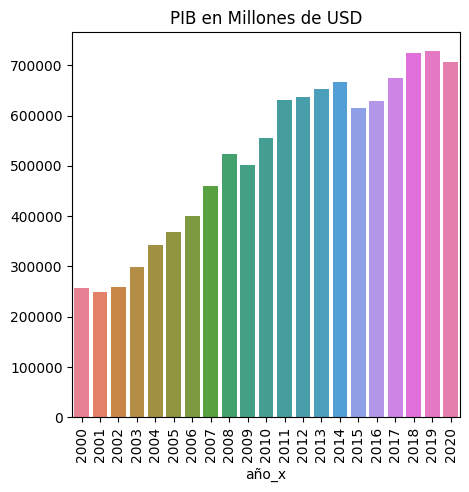

In [15]:
fig,ax = plt.subplots(1,sharex=True,figsize=(5,5))
ax = sns.barplot(timeline('total_gdp_million'))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('PIB en Millones de USD')
plt.show()

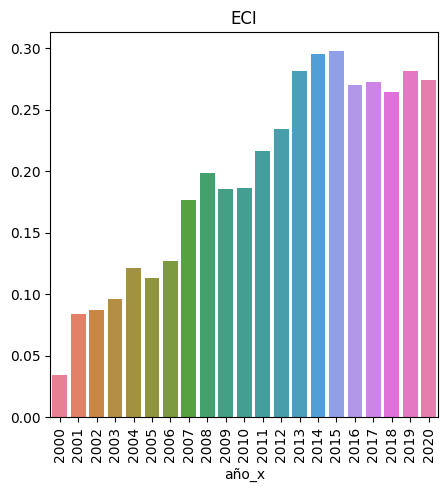

In [16]:
fig,ax = plt.subplots(1,sharex=True,figsize=(5,5))
ax = sns.barplot(timeline('ECI'))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('ECI')
plt.show()

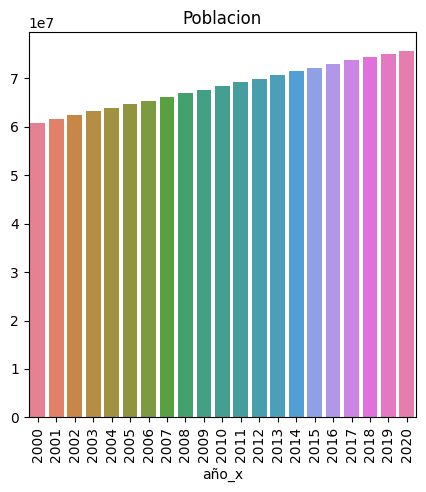

In [17]:
fig,ax = plt.subplots(1,sharex=True,figsize=(5, 5))
ax = sns.barplot(timeline('Poblacion'))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Poblacion')
plt.show()

In [18]:
print(f'Hay un total de {len(Data.Pais_x.unique())} paises con los cuales trabajar')

Hay un total de 75 paises con los cuales trabajar


## **Etapa 2: Revisar problemas en Series de Tiempo**

In [19]:
from pycaret.regression import *
from pycaret.regression import RegressionExperiment
from statsmodels.stats.outliers_influence import variance_inflation_factor
exp = RegressionExperiment()

In [20]:
X = Data[['Poblacion', 'ECI', 'año_x', 'Ecuador']]
Y = Data['total_gdp_million']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [22]:
Data

,Pais_x,Poblacion,total_gdp_million,ECI,año_x,Ecuador,año
0,Algeria,42705368.0,171767.403700,-1.042459,2019,0,2019-01
1,Algeria,43451666.0,145009.181500,-1.206390,2020,0,2020-01
2,Algeria,30774621.0,54790.392750,-1.064802,2000,0,2000-01
3,Algeria,31200985.0,54744.712810,-0.804064,2001,0,2001-01
4,Algeria,31624696.0,56760.355870,-0.994074,2002,0,2002-01
...,...,...,...,...,...,...,...
1570,Zimbabwe,11984644.0,6342.116400,-0.342388,2002,1,2002-01
1571,Zimbabwe,11910978.0,6777.384700,-0.393783,2001,1,2001-01
1572,Zimbabwe,11834676.0,6689.957600,-0.288579,2000,1,2000-01
1573,Zimbabwe,12679810.0,9665.793264,-0.381771,2009,1,2009-01


### ***Revisar Multicolinealidad***

In [23]:
variables = Data_final.drop(columns=['Pais_x'])
vif_data = pd.DataFrame()
vif_data["Variable"] = variables.columns
vif_data["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

In [24]:
print("\nVIF:")
print(vif_data)


VIF:
            Variable       VIF
0          Poblacion  1.781558
1  total_gdp_million  2.157813
2                ECI  1.609753
3              año_x  2.499387
4            Ecuador  2.434782


Existe multicolinealidad leve entre los datos entre los datos, por lo que no necesariamente se debe eliminarla pues al ser una multicolinalidad moderada el modelo de regresion lineal puede seguir haciendo predicciones de manera correcta

### ***Revisar Autocorrelacion***

In [25]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics import tsaplots
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller

In [26]:
X = np.array(Data_final.ECI)

In [27]:
sm.tsa.acf (X)

array([ 1.        ,  0.93415228,  0.8822679 ,  0.83326927,  0.77894522,
        0.73213627,  0.68247589,  0.63280588,  0.58410197,  0.53776899,
        0.48695291,  0.43925635,  0.38624893,  0.33911762,  0.29653167,
        0.25193233,  0.20665067,  0.16616246,  0.12236616,  0.07985138,
        0.0391977 , -0.00415941, -0.00252875,  0.00209584,  0.00827472,
        0.0129243 ,  0.01555542,  0.02091416,  0.02548139,  0.03079507,
        0.03464726,  0.03835648])

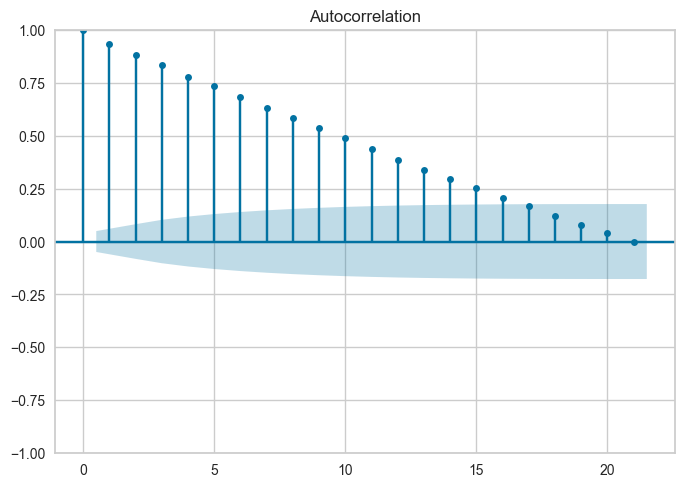

In [28]:
fig = tsaplots.plot_acf(X,lags=21)
plt.show ()

In [29]:
model_1 = ols('total_gdp_million ~ Poblacion + ECI + Ecuador', data=Data_final).fit()
durbin_watson(model_1.resid)

0.28431927577944044

In [30]:
model_2 = ols('total_gdp_million ~ Poblacion + Ecuador ', data=Data_final).fit()
durbin_watson(model_2.resid)

0.273151820843164

In [31]:
model_3 = ols('total_gdp_million ~ ECI + Poblacion ', data=Data_final).fit()
durbin_watson(model_3.resid)

0.2823922478876901

* En este caso se observa que el modelo muestra autocorrelacion pues se trata de Datos de panel los cuales tienen una componente temporal, en este caso la prueba de DurbiWatson para los 3 modelos arroja el valor de ***ρ*** cercado a 0 [0.28,0.27,1.8] entrando en el rango de 0<***ρ***<1 dando un DW = 2 (Durbin Watson) dando como resultado que el dataset tiene autocorrelacion positiva , lo que se refuerza al ver la grafica la cual solo en el rezago 21 tiene autocorrelacion de 0, mietras que a lo largo de la grafica siempre se observo que la autocorrelacion fue bajando pocco a poco.

* El problema de que exista autocorrelacion es que el modelo al usar regresion lineal tendra problemas a la hora ajsutar el modelo pues puede generar un Coeficiente de Determinacion muy perfecto R<sup>2</sup>=1, lo que haria que existe overfitting en el modelo imposibilidanto la generalizacion de los datos.


### ***Revisar Estacionariedad***

In [32]:
import plotly.express as px
Data_glob = pd.pivot_table(Data,index='año',values=['total_gdp_million','Poblacion','ECI'],aggfunc='sum').reset_index()
Data_glob['Time'] = pd.to_datetime(Data_glob['año'])
Data_glob = Data_glob.sort_values(by='Time')
fig = px.line(Data_glob, x="Time", y=["total_gdp_million"], template = 'plotly_dark')
fig.show()

In [33]:
D_fuller = adfuller(Data_glob.total_gdp_million,autolag='AIC')
print(f'El Estadistico D-Fuller es: {D_fuller[0]}')
print(f'El p-valor es de: {D_fuller[1]}. No rechazo H0, por lo que la serie para el PIB tiene comportamiento NO Estacional')

El Estadistico D-Fuller es: -1.1793378898436007
El p-valor es de: 0.6824202844756092. No rechazo H0, por lo que la serie para el PIB tiene comportamiento NO Estacional


In [34]:
D_fuller = adfuller(Data_glob.Poblacion,autolag='AIC')
print(f'El Estadistico D-Fuller es: {D_fuller[0]}')
print(f'El p-valor es de: {D_fuller[1]}. rechazo H0, por lo que la serie para la Poblacion es Estacional')

El Estadistico D-Fuller es: -2.964283780870511
El p-valor es de: 0.03836715950778153. rechazo H0, por lo que la serie para la Poblacion es Estacional


In [35]:
D_fuller = adfuller(Data_glob.ECI,autolag='AIC')
print(f'El Estadistico D-Fuller es: {D_fuller[0]}')
print(f'El p-valor es de: {D_fuller[1]}. No rechazo H0, por lo que la serie tiene comportamiento NO Estacional')

El Estadistico D-Fuller es: -1.1553311905910721
El p-valor es de: 0.6925101184130171. No rechazo H0, por lo que la serie tiene comportamiento NO Estacional


El valor de p > 0.05 NO rechaza la hipotesis Nula, por lo que se puede decir que la serie de tiempo NO tiene un comportamiento estacional

In [36]:
# from pmdarima import plot_acf

# plt.rcParams.update({'figure.figsize':(10,10), 'figure.dpi':120})
# fig,axes = plt.subplots(3,2,sharex=False)

# axes[0,0].plot(Data_glob.total_gdp_million);axes[0,0].set_title('Original')
# plot_acf(Data_glob.total_gdp_million,ax=axes[0,1])

# axes[1,0].plot(Data_glob.total_gdp_million);axes[1,0].set_title('1 AR')
# plot_acf(Data_glob.total_gdp_million.diff().dropna(),ax=axes[1,1],color='g')

# axes[2,0].plot(Data_glob.total_gdp_million);axes[2,0].set_title('2 AR')
# plot_acf(Data_glob.total_gdp_million.diff().diff().dropna(),ax=axes[2,1],color='b')
# plt.show()

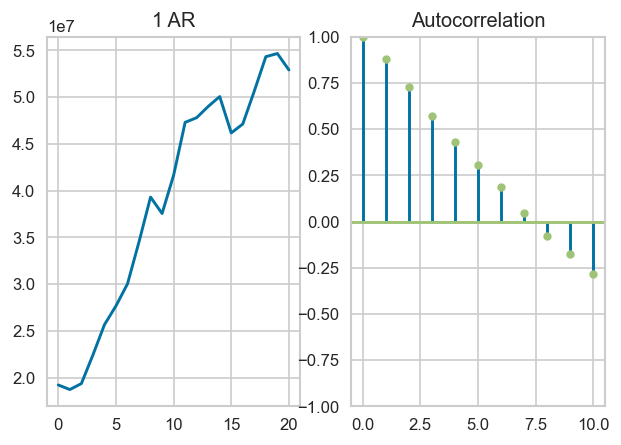

In [37]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
fig,axes = plt.subplots(1,2)
axes[0].plot(Data_glob.total_gdp_million);axes[0].set_title('1 AR')
plot_acf(Data_glob.total_gdp_million,ax=axes[1],color='g')

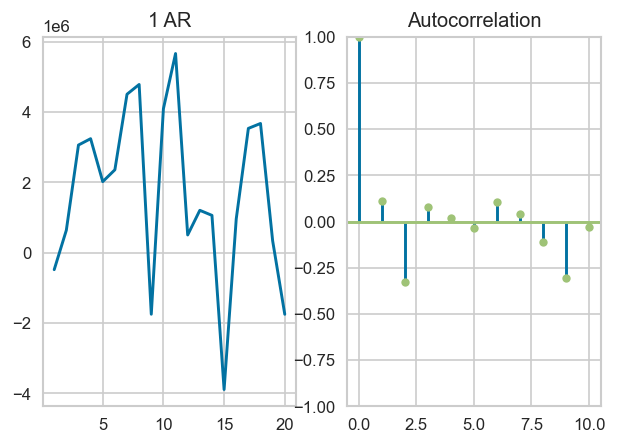

In [38]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
fig,axes = plt.subplots(1,2)
axes[0].plot(Data_glob.total_gdp_million.diff());axes[0].set_title('1 AR')
plot_acf(Data_glob.total_gdp_million.diff().dropna(),ax=axes[1],color='g')

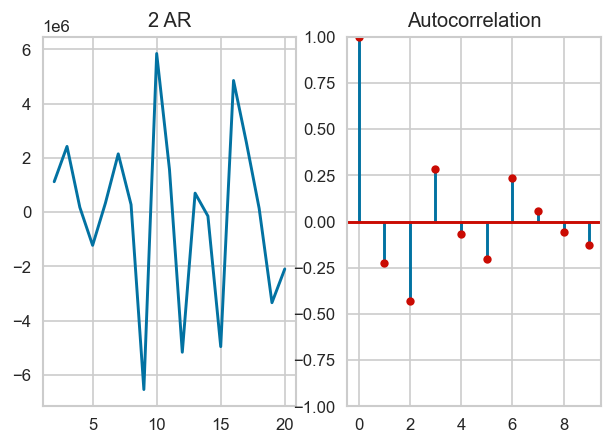

In [39]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
fig,axes = plt.subplots(1,2)
axes[0].plot(Data_glob.total_gdp_million.diff().diff());axes[00].set_title('2 AR')
plot_acf(Data_glob.total_gdp_million.diff().diff().dropna(),ax=axes[1],color='r')

In [40]:
Data_final

,Pais_x,Poblacion,total_gdp_million,ECI,año_x,Ecuador
0,Algeria,42705368.0,171767.403700,-1.042459,2019,0
1,Algeria,43451666.0,145009.181500,-1.206390,2020,0
2,Algeria,30774621.0,54790.392750,-1.064802,2000,0
3,Algeria,31200985.0,54744.712810,-0.804064,2001,0
4,Algeria,31624696.0,56760.355870,-0.994074,2002,0
...,...,...,...,...,...,...
1570,Zimbabwe,11984644.0,6342.116400,-0.342388,2002,1
1571,Zimbabwe,11910978.0,6777.384700,-0.393783,2001,1
1572,Zimbabwe,11834676.0,6689.957600,-0.288579,2000,1
1573,Zimbabwe,12679810.0,9665.793264,-0.381771,2009,1


### ***Eliminar Autocorrelacion y No estacionariedad***

In [41]:
def resagos(Data,columnas,n,pais):
    A = pd.DataFrame()
    for i in range(len(columnas)):
        
        A[columnas[i]] = (Data[Data['Pais_x']==pais])[(columnas[i])].diff(periods=n).dropna()
    # A[columnas[1]] = (Data[Data['Pais_x']==pais])[(columnas[1])].diff(periods=n).dropna()
        A['Pais'] = pais
        A['Ecuador'] = Data[Data['Pais_x']==pais]['Ecuador']
        A['Poblacion'] = Data[Data['Pais_x']==pais]['Poblacion']
        A['Año'] = Data[Data['Pais_x']==pais]['año_x']
    
    return A

In [42]:
Data_final

,Pais_x,Poblacion,total_gdp_million,ECI,año_x,Ecuador
0,Algeria,42705368.0,171767.403700,-1.042459,2019,0
1,Algeria,43451666.0,145009.181500,-1.206390,2020,0
2,Algeria,30774621.0,54790.392750,-1.064802,2000,0
3,Algeria,31200985.0,54744.712810,-0.804064,2001,0
4,Algeria,31624696.0,56760.355870,-0.994074,2002,0
...,...,...,...,...,...,...
1570,Zimbabwe,11984644.0,6342.116400,-0.342388,2002,1
1571,Zimbabwe,11910978.0,6777.384700,-0.393783,2001,1
1572,Zimbabwe,11834676.0,6689.957600,-0.288579,2000,1
1573,Zimbabwe,12679810.0,9665.793264,-0.381771,2009,1


In [43]:
n =  10
pais_unico = list(set(Data_final['Pais_x']))
PIB = []
Data_no_auto = pd.DataFrame()
for x in range(len(set(Data_final['Pais_x']))):
    PIB.append(resagos(Data_final,columnas = ['total_gdp_million','ECI'],n=n,pais=pais_unico[x]))
Data_no_auto = pd.concat(PIB,ignore_index= True)
# Data_no_auto[Data_no_auto['Pais']=='Slovenia']
# Data_no_auto
data_glob = Data_no_auto.copy()
data_glob['Año'] = ["".join([str(data_glob.iloc[i,4]),"-01"]) for i in range(len(data_glob.Año))]
data_glob = pd.pivot_table(data_glob,index='Año',values=['total_gdp_million','Poblacion','ECI'],aggfunc='sum').reset_index()
data_glob['Time'] = pd.to_datetime(data_glob['Año'])
data_glob = data_glob.sort_values(by='Time')
fig = px.line(data_glob, x="Time", y=["total_gdp_million"], template = 'plotly_dark')
fig.show()

In [44]:
Data_no_auto

,total_gdp_million,Pais,Ecuador,Poblacion,Año,ECI
0,83995.5216,Finland,0,5508214.0,2017,-0.195394
1,88236.8671,Finland,0,5313399.0,2008,-0.145695
2,100366.8911,Finland,0,5495303.0,2016,-0.166914
3,-21843.6854,Finland,0,5479531.0,2015,-0.086978
4,148843.2834,Finland,0,5461512.0,2014,-0.041529
...,...,...,...,...,...,...
820,201014.4306,Mexico,1,121519221.0,2016,0.315044
821,183525.9043,Mexico,1,122839258.0,2017,0.352142
822,-131892.8130,Mexico,1,125998302.0,2020,-0.011692
823,57292.7820,Mexico,1,109684489.0,2008,0.099763


In [45]:
Data_final

,Pais_x,Poblacion,total_gdp_million,ECI,año_x,Ecuador
0,Algeria,42705368.0,171767.403700,-1.042459,2019,0
1,Algeria,43451666.0,145009.181500,-1.206390,2020,0
2,Algeria,30774621.0,54790.392750,-1.064802,2000,0
3,Algeria,31200985.0,54744.712810,-0.804064,2001,0
4,Algeria,31624696.0,56760.355870,-0.994074,2002,0
...,...,...,...,...,...,...
1570,Zimbabwe,11984644.0,6342.116400,-0.342388,2002,1
1571,Zimbabwe,11910978.0,6777.384700,-0.393783,2001,1
1572,Zimbabwe,11834676.0,6689.957600,-0.288579,2000,1
1573,Zimbabwe,12679810.0,9665.793264,-0.381771,2009,1


## **Etapa 3: Crear y Evaluar Modelos con Pycaret**

### ***Data***

In [46]:
std = StandardScaler()
std.fit(Data_final[['total_gdp_million']])
Data_final['total_gdp_million']= std.transform(Data_final[['total_gdp_million']])
std.fit(Data_final[['Poblacion']])
Data_final['Poblacion']= std.transform(Data_final[['Poblacion']])
Data_final_2  = Data_final.drop(columns=['Pais_x'],axis=1)
Data_final_2

,Poblacion,total_gdp_million,ECI,año_x,Ecuador
0,-0.123399,-0.283150,-1.042459,2019,0
1,-0.119818,-0.305020,-1.206390,2020,0
2,-0.180644,-0.378758,-1.064802,2000,0
3,-0.178598,-0.378796,-0.804064,2001,0
4,-0.176565,-0.377148,-0.994074,2002,0
...,...,...,...,...,...
1570,-0.270800,-0.418356,-0.342388,2002,1
1571,-0.271153,-0.418000,-0.393783,2001,1
1572,-0.271519,-0.418072,-0.288579,2000,1
1573,-0.267464,-0.415640,-0.381771,2009,1


In [47]:
reg = setup(Data_final_2, target = 'total_gdp_million', session_id = 123,remove_multicollinearity=True)

,Description,Value
0,Session id,123
1,Target,total_gdp_million
2,Target type,Regression
3,Original data shape,"(1575, 5)"
4,Transformed data shape,"(1575, 5)"
5,Transformed train set shape,"(1102, 5)"
6,Transformed test set shape,"(473, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [48]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0444,0.0154,0.1054,0.9853,0.0451,0.3794,0.0210
rf,Random Forest Regressor,0.0776,0.0856,0.2196,0.9183,0.0768,0.4537,0.0290
gbr,Gradient Boosting Regressor,0.1229,0.0815,0.2457,0.9133,0.1087,0.9615,0.0160
lightgbm,Light Gradient Boosting Machine,0.1106,0.1099,0.2921,0.8975,0.1007,0.7146,0.1110
dt,Decision Tree Regressor,0.0963,0.1424,0.3113,0.8301,0.1054,0.5288,0.0050
ada,AdaBoost Regressor,0.3741,0.2601,0.4837,0.6442,0.2147,2.5735,0.0140
br,Bayesian Ridge,0.4093,0.5629,0.7271,0.3295,0.2671,3.2042,0.0070
ridge,Ridge Regression,0.4098,0.5630,0.7273,0.3284,0.2671,3.2143,0.1400
lar,Least Angle Regression,0.4099,0.5631,0.7274,0.3282,0.2671,3.2167,0.0060
lr,Linear Regression,0.4099,0.5631,0.7274,0.3282,0.2671,3.2167,0.2210


In [49]:
reg = setup(Data_final_2, target = 'total_gdp_million', session_id = 123,remove_multicollinearity=False)

,Description,Value
0,Session id,123
1,Target,total_gdp_million
2,Target type,Regression
3,Original data shape,"(1575, 5)"
4,Transformed data shape,"(1575, 5)"
5,Transformed train set shape,"(1102, 5)"
6,Transformed test set shape,"(473, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [50]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0444,0.0154,0.1054,0.9853,0.0451,0.3794,0.0200
rf,Random Forest Regressor,0.0776,0.0856,0.2196,0.9183,0.0768,0.4537,0.0310
gbr,Gradient Boosting Regressor,0.1229,0.0815,0.2457,0.9133,0.1087,0.9615,0.0180
lightgbm,Light Gradient Boosting Machine,0.1106,0.1099,0.2921,0.8975,0.1007,0.7146,0.1150
dt,Decision Tree Regressor,0.0963,0.1424,0.3113,0.8301,0.1054,0.5288,0.0050
ada,AdaBoost Regressor,0.3741,0.2601,0.4837,0.6442,0.2147,2.5735,0.0130
br,Bayesian Ridge,0.4093,0.5629,0.7271,0.3295,0.2671,3.2042,0.0050
ridge,Ridge Regression,0.4098,0.5630,0.7273,0.3284,0.2671,3.2143,0.0040
lar,Least Angle Regression,0.4099,0.5631,0.7274,0.3282,0.2671,3.2167,0.0040
lr,Linear Regression,0.4099,0.5631,0.7274,0.3282,0.2671,3.2167,0.0060


In [51]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### ***Data No Autocorrelation***

In [52]:
std = StandardScaler()
Data_no_auto

,total_gdp_million,Pais,Ecuador,Poblacion,Año,ECI
0,83995.5216,Finland,0,5508214.0,2017,-0.195394
1,88236.8671,Finland,0,5313399.0,2008,-0.145695
2,100366.8911,Finland,0,5495303.0,2016,-0.166914
3,-21843.6854,Finland,0,5479531.0,2015,-0.086978
4,148843.2834,Finland,0,5461512.0,2014,-0.041529
...,...,...,...,...,...,...
820,201014.4306,Mexico,1,121519221.0,2016,0.315044
821,183525.9043,Mexico,1,122839258.0,2017,0.352142
822,-131892.8130,Mexico,1,125998302.0,2020,-0.011692
823,57292.7820,Mexico,1,109684489.0,2008,0.099763


In [53]:
std.fit(Data_no_auto[['total_gdp_million']])
Data_no_auto['total_gdp_million']= std.transform(Data_no_auto[['total_gdp_million']])
std.fit(Data_no_auto[['Poblacion']])
Data_no_auto['Poblacion']= std.transform(Data_no_auto[['Poblacion']])
Data_no_auto

,total_gdp_million,Pais,Ecuador,Poblacion,Año,ECI
0,0.242168,Finland,0,-0.304083,2017,-0.195394
1,0.246738,Finland,0,-0.305050,2008,-0.145695
2,0.259810,Finland,0,-0.304147,2016,-0.166914
3,0.128112,Finland,0,-0.304225,2015,-0.086978
4,0.312050,Finland,0,-0.304315,2014,-0.041529
...,...,...,...,...,...,...
820,0.368271,Mexico,1,0.271985,2016,0.315044
821,0.349425,Mexico,1,0.278540,2017,0.352142
822,0.009519,Mexico,1,0.294227,2020,-0.011692
823,0.213392,Mexico,1,0.213218,2008,0.099763


In [54]:
train = Data_no_auto[Data_no_auto['Año'] < 2019]
test = Data_no_auto[Data_no_auto['Año'] >= 2019]
print(train.shape)
print(test.shape)

(757, 6)
(68, 6)


In [55]:
B = setup(data = train, test_data = test,target ='total_gdp_million',fold_strategy = 'timeseries',
          ignore_features=['Pais'],fold = 2, session_id = 123,
          data_split_shuffle=False,fold_shuffle=False)

,Description,Value
0,Session id,123
1,Target,total_gdp_million
2,Target type,Regression
3,Original data shape,"(825, 6)"
4,Transformed data shape,"(825, 5)"
5,Transformed train set shape,"(757, 5)"
6,Transformed test set shape,"(68, 5)"
7,Ignore features,1
8,Numeric features,4
9,Preprocess,True


In [56]:
best_auto = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.3459,1.2873,0.9700,0.2377,0.2862,1.3504,0.0150
lar,Least Angle Regression,0.3459,1.2873,0.9700,0.2377,0.2862,1.3504,0.0150
ridge,Ridge Regression,0.3476,1.2881,0.9706,0.2359,0.2885,1.3557,0.0150
knn,K Neighbors Regressor,0.3421,1.2134,0.9539,0.2244,0.2970,1.5204,0.0250
et,Extra Trees Regressor,0.3288,1.2499,0.9653,0.2154,0.2941,1.6203,0.0600
huber,Huber Regressor,0.3465,1.1820,0.9493,0.2050,0.2664,1.4086,0.0200
br,Bayesian Ridge,0.3538,1.3008,0.9814,0.1997,0.3049,1.3766,0.0150
gbr,Gradient Boosting Regressor,0.3373,1.3185,0.9917,0.1710,0.3009,1.7367,0.0400
rf,Random Forest Regressor,0.3296,1.3526,1.0003,0.1703,0.3096,1.3127,0.0800
ada,AdaBoost Regressor,0.3577,1.4341,1.0227,0.1559,0.3160,1.3822,0.0350


In [57]:
evaluate_model(best_auto)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## **PRUEBA**

In [58]:
data = pd.read_csv('AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])
data.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [59]:
data['MA12'] = data['#Passengers'].rolling(12).mean()
data

,Month,#Passengers,MA12
0,1949-01-01,112,NaN
1,1949-02-01,118,NaN
2,1949-03-01,132,NaN
3,1949-04-01,129,NaN
4,1949-05-01,121,NaN
...,...,...,...
139,1960-08-01,606,463.333333
140,1960-09-01,508,467.083333
141,1960-10-01,461,471.583333
142,1960-11-01,390,473.916667


In [60]:
import plotly.express as px
fig = px.line(data, x="Month", y=["#Passengers", "MA12"], template = 'plotly_dark')
fig.show()

In [61]:
data['Mes'] = [i.month for i in data['Month']]
data['Year'] = [i.year for i in data['Month']]

In [62]:
data['Series'] = np.arange(1,len(data)+1)

In [63]:
data.drop(['Month', 'MA12'], axis=1, inplace=True)
data = data[['Series', 'Year', 'Mes', '#Passengers']]

In [64]:
D_fuller = adfuller(data['#Passengers'],autolag='AIC')
print(f'El EStadistico D-Fuller es: {D_fuller[0]}')
print(f'El p-valor es de: {D_fuller[1]}')

El EStadistico D-Fuller es: 0.8153688792060352
El p-valor es de: 0.9918802434376408


In [65]:
data

,Series,Year,Mes,#Passengers
0,1,1949,1,112
1,2,1949,2,118
2,3,1949,3,132
3,4,1949,4,129
4,5,1949,5,121
...,...,...,...,...
139,140,1960,8,606
140,141,1960,9,508
141,142,1960,10,461
142,143,1960,11,390


In [66]:
train = data[data['Year'] < 1960]
test = data[data['Year'] >= 1960]
print(train.shape)
print(test.shape)

(132, 4)
(12, 4)


In [67]:
s = setup(data = train, test_data = test, target = '#Passengers', fold_strategy = 'timeseries', 
          numeric_features = ['Year', 'Series'], fold = 3, transform_target = True, session_id = 123,
          data_split_shuffle=False,fold_shuffle=False)

,Description,Value
0,Session id,123
1,Target,#Passengers
2,Target type,Regression
3,Original data shape,"(144, 4)"
4,Transformed data shape,"(144, 4)"
5,Transformed train set shape,"(132, 4)"
6,Transformed test set shape,"(12, 4)"
7,Numeric features,2
8,Preprocess,True
9,Imputation type,simple


In [68]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,44.3192,3050.6952,53.8852,-0.4522,0.1714,0.1521,0.0133
br,Bayesian Ridge,45.5643,3233.7133,55.6766,-0.6553,0.1765,0.1576,0.0133
ridge,Ridge Regression,45.7835,3257.2206,55.8542,-0.6687,0.1770,0.1585,0.0133
lr,Linear Regression,45.7967,3258.3784,55.8611,-0.6705,0.1770,0.1586,0.0100
lar,Least Angle Regression,45.8053,3260.6009,55.8841,-0.6721,0.1771,0.1586,0.0133
huber,Huber Regressor,46.0420,3308.9725,56.4600,-0.8186,0.1802,0.1618,0.0167
lasso,Lasso Regression,51.7106,3939.2790,61.4955,-1.4896,0.2374,0.1830,0.0133
llar,Lasso Least Angle Regression,51.7106,3939.2790,61.4955,-1.4896,0.2374,0.1830,0.0133
gbr,Gradient Boosting Regressor,52.4896,4355.4048,63.7434,-0.7220,0.2142,0.1618,0.0233
en,Elastic Net,52.5924,3937.1760,61.2301,-1.4778,0.2367,0.1870,0.0133
